In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
 !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
data_path = Path(base_dir + 'data/')
data_path.mkdir(parents=True, exist_ok=True)

In [0]:
np.random.seed(2)
bs = 64
# bs = 16   # 

In [0]:
train_data = pd.read_csv('/content/gdrive/My Drive/fastai-v3/data/Cats_and_Dogs_Datasets/train.csv')
train_data['id'] = train_data['id'].astype(str) + ".jpg"
train_data['class_name'] = train_data['class_name'].astype('category')
train_data['breed'] = train_data['breed'].astype('category')
train_data.head()

,id,class_name,breed
0,img_1313.jpg,1,11
1,img_0642.jpg,2,21
2,img_1450.jpg,1,11
3,img_2201.jpg,1,12
4,img_0964.jpg,2,21


In [0]:
test_data = pd.read_csv('/content/gdrive/My Drive/fastai-v3/data/Cats_and_Dogs_Datasets/test.csv')
test_data['id'] = test_data['id'].astype(str) + ".jpg"
test_data.head()

,id
0,img_0966.jpg
1,img_6542.jpg
2,img_2360.jpg
3,img_0763.jpg
4,img_6579.jpg


In [0]:
train_path = Path(data_path/'Cats_and_Dogs_Datasets/images_train')
test_path = Path(data_path/'Cats_and_Dogs_Datasets/images_test')

In [0]:
data = ImageDataBunch.from_df(path = train_path, df = train_data, valid_pct = 0.05, label_col = 'class_name', ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

In [0]:
data.train_ds

LabelList (5896 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,2,1,1,2
Path: /content/gdrive/My Drive/fastai-v3/data/Cats_and_Dogs_Datasets/images_train

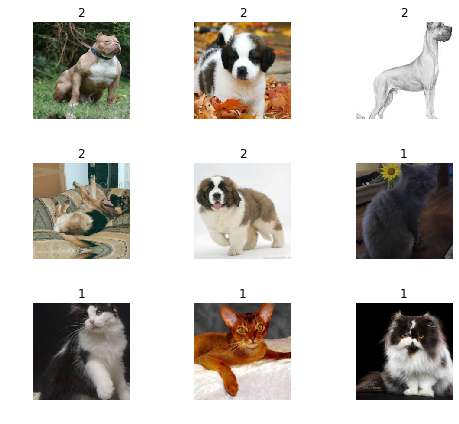

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
print(data.classes)
len(data.classes),data.c

[1, 2]


(2, 2)

In [0]:
learn_cn = cnn_learner(data, models.resnet50, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


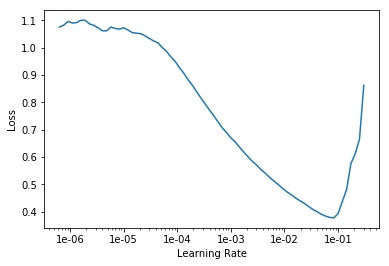

In [0]:
learn_cn.lr_find()
learn_cn.recorder.plot()

In [0]:
learn_cn.fit_one_cycle(4,slice(1e-4,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.078076,0.020681,0.993548,01:43
1,0.057511,0.013580,0.996774,01:36
2,0.033670,0.009256,0.996774,01:35
3,0.027747,0.004626,0.996774,01:34


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

[(2, 1, 11), (1, 2, 4)]

In [0]:
learn_cn.save(Path(data_path/'Cats_and_Dogs_Datasets/class_name_learner_4_epoch'))

In [0]:
learn_cn = learn_cn.load(Path(data_path/'Cats_and_Dogs_Datasets/class_name_learner_4_epoch'))

In [0]:
learn = learn.load(Path(data_path/'Cats_and_Dogs_Datasets/stage-1-50'))

In [0]:
pred_dict = {}
for file in test_path.ls():
  img = open_image(file)
  pred_dict[str(file).split("/")[-1].split(".")[0]] = learn.predict(img)[0].obj

In [0]:
buffer = []
for key, value in pred_dict.items():
  buffer.append({"id":key,"class_name":int(value.data)})

In [0]:
pd.DataFrame(buffer).to_excel(data_path/'Cats_and_Dogs_Datasets/half_pred.xlsx')

In [0]:
data_classes = ImageDataBunch.from_df(path = train_path, df = train_data, valid_pct = 0.05, label_col = 'breed', ds_tfms=get_transforms(), size=229, bs=bs).normalize(imagenet_stats)

In [0]:
data_classes.classes

[11, 12, 13, 14, 15, 21, 22, 23, 24, 25]

In [0]:
learn_breed = cnn_learner(data_classes, models.resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:06<00:00, 15975150.08it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


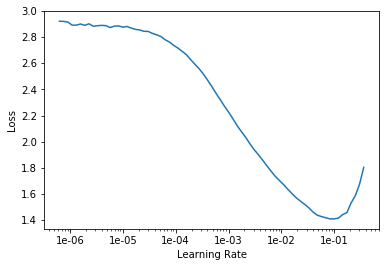

In [0]:
learn_breed.lr_find()
learn_breed.recorder.plot()

In [0]:
learn_breed.fit_one_cycle(5, slice(1e-4,1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.645637,0.685421,0.864516,02:39
1,1.857098,1.811381,0.777419,01:09
2,1.286278,0.605920,0.864516,01:09
3,0.648576,0.251292,0.912903,01:10
4,0.371015,0.218380,0.916129,01:09


In [0]:
learn_breed.save(Path(data_path/'Cats_and_Dogs_Datasets/learn_breed_5_epoch'))

In [0]:
learn_breed = learn_breed.load(Path(data_path/'Cats_and_Dogs_Datasets/learn_breed_5_epoch'))

In [0]:
pred_dict2 = {}
for file in test_path.ls():
  img = open_image(file)
  pred_dict2[str(file).split("/")[-1].split(".")[0]] = learn.predict(img)[0].obj

In [0]:
buffer = []
for key in pred_dict2.keys():
  temp = {}
  temp['id'] = key
  temp['class_name'] = pred_dict[key]
  temp['breed'] = pred_dict2[key]
  buffer.append(temp)

In [0]:
foo = pd.DataFrame(buffer)

In [0]:
foo['buffer'] = None

In [0]:
for idx, row in foo.iterrows():
  foo.at[idx, 'buffer'] = pred_dict2[row['id']]

In [0]:
foo = foo.drop(2, axis = 1)

In [0]:
foo = foo[['id','class_name','breed']]

In [0]:
foo.to_excel(data_path/'Cats_and_Dogs_Datasets/submission.xlsx', index = False)


In [0]:
learn.get_preds(data)

[tensor([[7.3911e-04, 9.9926e-01],
         [1.0000e+00, 3.5145e-07],
         [1.0000e+00, 5.0927e-07],
         ...,
         [4.3231e-05, 9.9996e-01],
         [1.8272e-05, 9.9998e-01],
         [1.0000e+00, 9.8646e-08]]), tensor([1, 0, 0,  ..., 1, 1, 0])]

In [0]:
learn_breed = learn_breed.load(Path(data_path/'Cats_and_Dogs_Datasets/stage-2-50'))

In [0]:

interp = ClassificationInterpretation.from_learner(learn_breed)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

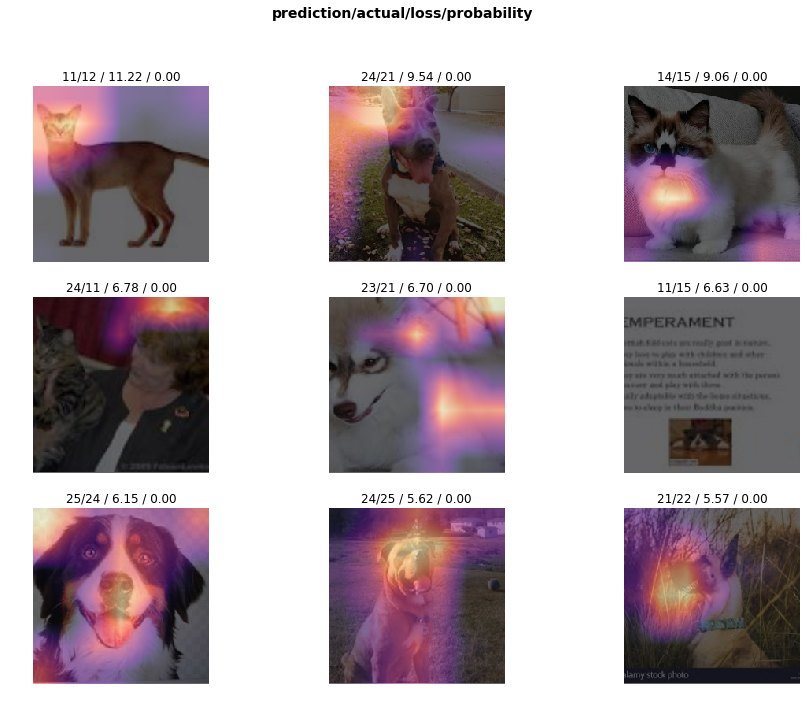

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

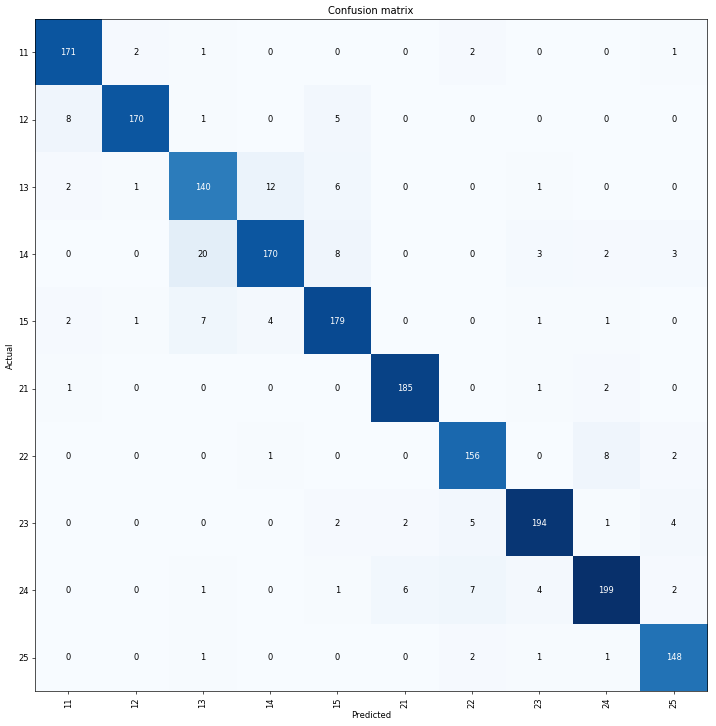

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
test_images = ImageList.from_df(df = test_data, path = test_path).split_none().label_empty().transform(get_transforms(),size = 229).databunch().normalize(imagenet_stats)

In [0]:
test_images

ImageDataBunch;

Train: LabelList (1096 items)
x: ImageList
Image (3, 229, 229),Image (3, 229, 229),Image (3, 229, 229),Image (3, 229, 229),Image (3, 229, 229)
y: EmptyLabelList
,,,,
Path: /content/gdrive/My Drive/fastai-v3/data/Cats_and_Dogs_Datasets/images_test;

Valid: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: /content/gdrive/My Drive/fastai-v3/data/Cats_and_Dogs_Datasets/images_test;

Test: None

In [0]:
my_preds = learn_breed.get_preds(test_images)

In [0]:
learn_cn = cnn_learner(data, models.resnet50, metrics=accuracy)
learn_cn = learn_cn.load(Path(data_path/'Cats_and_Dogs_Datasets/stage-1-50'))

In [0]:
my_preds_cn = learn_cn.get_preds(test_images)

In [0]:
pd.DataFrame({"breed": new_clas }).to_csv(data_path/'Cats_and_Dogs_Datasets/breed.csv')

In [0]:
clas = list(my_preds[1])

In [0]:
map_back = {}

In [0]:
for i in range(len(data_classes.classes)):
  map_back[i] = data_classes.classes[i]

In [0]:
map_back

{0: 11, 1: 12, 2: 13, 3: 14, 4: 15, 5: 21, 6: 22, 7: 23, 8: 24, 9: 25}

In [0]:
new_clas = [map_back[int(x)] for x in my_preds[1]]

In [0]:
len(my_preds[1])

5896

In [0]:
final = pd.DataFrame(final_results)
final = final[['id','class_name','breed']]
final.to_excel(data_path/'Cats_and_Dogs_Datasets/final.xlsx')

In [0]:
final_results = []
for file in test_path.ls():
  img = open_image(file)
  img.show()
  id = str(file).split("/")[-1].split(".")[0]
  class_name = int(learn_cn.predict(img)[0].obj)
  breed =  int(learn_breed.predict(img)[0].obj)
  final_results.append({"id":id, "class_name":class_name,"breed":breed})